# Replay buffer and Deep Q-Networks 

In [1]:
# General imports
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from tqdm.auto import tqdm

# Create graphs folder
Path("graphs/").mkdir(exist_ok=True)

### Implement Replay Buffer

Deep Q-learning commonly uses replay buffers for the following purposes:
- To reuse samples of old episodes
- To break high correlation between similar trajectories & neighboring data points

This replay buffer stores ($s_t$, $a_t$, $r_t$, $s_{t+1}$, $d_t$) tuples, denoting a transition from state $s_t$ to $s_{t+1}$ via the action at while observing the reward $r_t$. $d_t$ is a binary flag indicating whether the episode terminated with that transition.


In [2]:
class ReplayBuffer(object):
    def __init__(self, mem_size, state_shape): 
        """Initialization of the replay buffer.
        
        The memories have the following data types:
            states: float32
            next_states: float32
            actions: int64
            rewards: float32
            is_terminal: bool

        Args:
            mem_size: Capacity of this buffer
            state_shape: Shape of state and next_state
        """
        self.mem_size = mem_size  # Capacity of the buffer
        self.mem_cntr = 0         # Number of added elements
        
        self.state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
#         self.buffer = collections.deque(maxlen=mem_size)
    
    def is_filled(self):
        """Check if the memory is filled."""
        return self.mem_cntr >= self.mem_size

    def add(self, state, action, reward, next_state, is_terminal):
        """Add one transition to the buffer.

        Replaces the oldest transition in memory.
        """
        #tracking number of objects
        self.mem_cntr += 1 
        
        #state memory
        self.state_memory = np.delete(self.state_memory, 0, 0)
        self.state_memory = np.append(self.state_memory, np.reshape(state, (1,-1)), axis=0)
        
        #next_state memory
        self.next_state_memory = np.delete(self.next_state_memory, 0, 0)
        self.next_state_memory = np.append(self.next_state_memory, np.reshape(next_state, (1,-1)), axis=0)
        
        #action_memory
        self.action_memory = np.delete(self.action_memory, 0)
        self.action_memory = np.append(self.action_memory, action)
        
        #reward
        self.reward_memory = np.delete(self.reward_memory, 0)
        self.reward_memory = np.append(self.reward_memory, reward)
        
        #terminal_memory
        self.terminal_memory = np.delete(self.terminal_memory, 0)
        self.terminal_memory = np.append(self.terminal_memory, is_terminal)

    def sample_batch(self, batch_size):
        """Sample one batch from the memory."""
        
        #sampling indices
        arr = np.random.choice(self.mem_size,batch_size, replace=False)
        
        #sampling values
        states = self.state_memory[arr]
        actions = self.action_memory[arr]
        rewards = self.reward_memory[arr]
        next_states = self.next_state_memory[arr]
        is_terminal = self.terminal_memory[arr]

        return states, actions, rewards, next_states, is_terminal

In [3]:
# Test code
_buffer = ReplayBuffer(10, (5,))
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 0
for i in range(10): # Fill test values
    _buffer.add(np.arange(5)+i , 5+i, 6+i, 7+np.arange(5)+i, (12+i)%2 == 0)
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 10, "Wrong mem_cntr"

_is = set()
for s, a, r, s_, t in zip(*_buffer.sample_batch(5)):
    i = s[0]
    assert 0 <= i < 10, "Wrong states"
    _is.add(i)
    np.testing.assert_array_equal(s, np.arange(5)+i, err_msg="Wrong states")
    np.testing.assert_equal(a, 5+i, err_msg="Wrong actions")
    np.testing.assert_equal(r, 6+i, err_msg="Wrong rewards")
    np.testing.assert_array_equal(s_, 7+np.arange(5)+i, err_msg="Wrong next states")
    np.testing.assert_equal(t, (12+i)%2 == 0, err_msg="Wrong terminals")
assert len(_is) == 5, "Duplicate transitions"
"ok"

'ok'

### Fill replay buffer

Samples transitions from environment and add to buffer

In [4]:
env = gym.make('CartPole-v1')

# Initialize replay buffer
buffer = ReplayBuffer(mem_size=25000, state_shape=env.observation_space.shape)

env.reset() 
while not buffer.is_filled(): #Run till buffer not filled
    
    # Run one episode
    state, done = env.reset(), False
    while not done:
        # Take random steps
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        
        #fillin the buffer
        buffer.add(state, action, reward, next_state, done)
        state = next_state


In [5]:
# Test code
assert buffer.is_filled(), f"Buffer not filled, only {buffer.mem_cntr}/{buffer.mem_size} transitions in memory"
"ok"

'ok'


### Define Deep Q-Network

In [6]:
import torch
from torch import nn
import torch.nn.functional as F

#Testing with same as Question A2
class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
        self.hidden_layer = nn.Linear(env.observation_space.shape[0], 128)
#         self.hidden_layer2 = nn.Linear(128, 256)
        self.out_layer = nn.Linear(128, env.action_space.n)
        self.leaky_relu = nn.LeakyReLU()
        
        #regularizers
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(256)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)


    def forward(self, x):
        x = torch.flatten(x.float(), start_dim=-1) #, start_dim=1 #Throwing error
        x= self.leaky_relu(self.hidden_layer(x))
        x= self.out_layer(x)

        return x

In [7]:
# Test code
_test_output = DeepQNetwork()(torch.FloatTensor([[1, 2, 3, 4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
"ok"

'ok'

## $\epsilon$-Greedy Policy

- **$\epsilon$-greedy** strategy used for action sampling to introduce **randomness** into the actions.
- **$\epsilon$-greedy** chooses a **random action with probability $\epsilon$** and uses the **optimal action otherwise.**
- **$\epsilon$-greedy** policy is mathematically given by:

<img src="./photos/elipson-greedy.png" width="500">


In [8]:
def epsilon_greedy(state, q_network, epsilon=0.05):
    """Performs epsilon-greedy action sampling.

    Args:
        state: numpy ndarray, current state
        q_network: torch module

    Returns:
        action: one action
    """

    sample = np.random.uniform(0, 1)
    
    if sample < epsilon: 
        action = env.action_space.sample()
    else:
        state = torch.FloatTensor(state)
        state_max = torch.max(state)

        action = q_network(state/state_max).data.max(-1)[1].item()
        
    return action

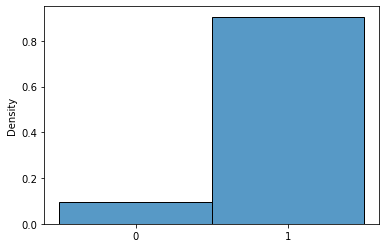

In [9]:
# Test Code
class DummyModule(nn.Module):
    def forward(self, state):
        return torch.FloatTensor([1,2]) # Constant output

# Sample 1000 actions
_actions = [epsilon_greedy(np.array([1,2,3,4]), DummyModule(), epsilon=0.2) for _ in range(1000)]

sns.histplot(_actions, discrete=True, stat="density")
plt.xticks([0,1])
plt.show()

_zeros = 1000 - sum(_actions)
# Note: This is a stochastic test. It produces a false error in 1% of the cases
assert 75 < _zeros < 125, f"Frequency of action 0 ({_zeros}) is outside the 99% confidence interval [76, 124]"

### Defining Loss Function

- **Loss Funtion** is given by:

<img src="./photos/loss-function.png" width="500">

- $\delta$ is a batch of transition samples
- $Q$($s_t$, $a_t$) are target $Q$-values in q_network and
- $\hat Q$ ($s_{t+1}$, $a_{t+1}$) in target_network.
- Loss is the difference of the current $Q$-value \& the expected $Q$-value.


In [10]:
mse = nn.MSELoss()

def compute_loss(q_network, target_network, states, actions, rewards, next_states, is_terminal, gamma=0.99):
   
    qvals = torch.gather(q_network.forward(states),1,actions)
    next_actions = torch.argmax(q_network.forward(next_states),dim=1, keepdim=True)
   
    qvals_next = torch.gather(target_network.forward(next_states), 1, next_actions).detach()
    qvals_next[is_terminal] = 0

    expected_qvals = gamma * qvals_next + rewards

    loss = mse(qvals, expected_qvals)
                
    return loss

### Training

  0%|          | 0/1000 [00:00<?, ?it/s]

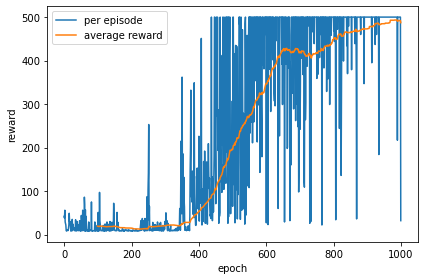

In [11]:
# Hyperparameters
epsilon = 0.05  #0.05 # For epsilon greedy action sampling
batch_size = 64 #64
NETWORK_UPDATE_FREQUENCY = 10  #4
NETWORK_SYNC_FREQUENCY = 2000 #2000
gamma = 0.99 #0.99
episodes = 1000
replay_buffer_size = 0

q_network = DeepQNetwork()

target_network = deepcopy(q_network)

optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-3)
mse = nn.MSELoss()

step_count = 0
total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        state, done = env.reset(), False
        rewards = []

        while not done:
            # Take a step

            action = epsilon_greedy(state, q_network, epsilon=epsilon) #problematic
            next_state, reward, done, _ = env.step(action)

            # Bookkeeping
            rewards.append(reward)
            buffer.add(state=state, action=action, reward=reward, next_state=next_state, is_terminal=done and env._elapsed_steps < 500)
            state = next_state

            step_count += 1

            # Update network every NETWORK_UPDATE_FREQUENCY steps
            if step_count % NETWORK_UPDATE_FREQUENCY == 0:
                
#                 Sample batch of transitions
                state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = buffer.sample_batch(batch_size=batch_size)
                state_batch = torch.FloatTensor(state_batch)
                next_state_batch = torch.FloatTensor(next_state_batch)
                action_batch = torch.LongTensor(action_batch).reshape(-1, 1)
                reward_batch = torch.FloatTensor(reward_batch).reshape(-1, 1)
                terminal_batch = torch.BoolTensor(terminal_batch)
                
                
#               Compute loss
                loss = compute_loss(q_network, target_network, state_batch, action_batch, reward_batch, next_state_batch, terminal_batch, gamma)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
           
            # Sync networks every NETWORK_SYNC_FREQUENCY steps
            if step_count % NETWORK_SYNC_FREQUENCY == 0:

                target_network.load_state_dict(q_network.state_dict())

        total_rewards.append(sum(rewards))

         # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")
        if np.mean(total_rewards[-100:]) == 500:
            break # Stop training

# Save model
with open("graphs/b2d.pt", "wb") as f:
    torch.save(q_network, f)

# Plot training
plt.plot(total_rewards, label="per episode")
plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("graphs/b2d.png")

In [12]:
# Test code
policy = q_network
policy.eval() # Switch to evaluation mode

def _rollout(seed):
    env.seed(seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps
        
_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

'ok (Average reward 500.00)'